In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from data_generator import DataGenerator

import model as model_util

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from numpy import array
import numpy as np


import datetime
from datetime import datetime

from tensorflow.keras.layers import BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences


from tensorflow.keras import datasets, layers, models

import tensorflow as tf

#%load_ext tensorboard
print(tf.__version__)

2.4.1


In [41]:
def reset_seed():
    seed_value= 0
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)
    

In [42]:
import random

path = "drive/My Drive/model/"
path = "./"

trainX = np.load(path + "train" + "X.npy")
trainY = np.load(path + "train" + "Y.npy")
print("Train")
print(trainX.shape)
print(trainY.shape)

valX = np.load(path + "val" + "X.npy")
valY = np.load(path + "val" + "Y.npy")
print("Validation")
print(valX.shape)
print(valY.shape)

def mapY(x): 
  result = 0
  if (x>0):
    result = 1
  return result

vfuncY = np.vectorize(lambda x: mapY(x))

def get_balanced_set(X, Y):
    positiveX = []
    positiveY = []
    negativeX = []
    negativeY = []

    for i in tqdm(range(1, len(X)-1)):
        x = X[i]
        y = Y[i]
        if (y == 1):
            positiveX.append(x)
            positiveY.append(y)
        else:
            negativeX.append(x)
            negativeY.append(y)
   
    positiveX = np.array(positiveX)
    positiveY = np.array(positiveY)
    negativeX = np.array(negativeX)
    negativeY = np.array(negativeY)
    
    print("Positives: {} Negatives {}".format(len(positiveX), len(negativeX)))
    
    negative_num = len(positiveY)
    start_index = random.randint(0,(len(negativeX) - negative_num))
    end_index = start_index + negative_num
    
    print("Ramdow {} {}".format(start_index, end_index))
    
    trainX = np.concatenate((positiveX, negativeX[start_index:end_index]), axis=0)
    trainY = np.concatenate((positiveY, negativeY[start_index:end_index]), axis=0)
    return trainX, trainY, positiveX, positiveY, negativeX, negativeY


trainX, trainY, positiveX, positiveY, negativeX, negativeY = get_balanced_set(trainX, trainY)

#valX, valY, positiveX_, positiveY_, negativeX_, negativeY_ = get_balanced_set(valX, valY)


print("Completed: {} {} {} {}".format(trainX.shape, trainY.shape, valX.shape, valY.shape))


Train
(7047, 13)
(7047,)
Validation
(21, 13)
(21,)



Positives: 484 Negatives 6561
Ramdow 510 994
Completed: (968, 13) (968,) (21, 13) (21,)


In [57]:
# define generator
seqs = 30

class CustomGen(TimeseriesGenerator):
    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        return x, y


def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def get_gen(set_x, set_y, shuffle=True, batch_size=512):
    #return create_dataset(set_x, set_y, seqs)
    return CustomGen(set_x, set_y, length=seqs, batch_size=batch_size, shuffle=shuffle)

train_generator = get_gen(negativeX, negativeY, shuffle=True)

#val_generator = get_gen(valX, valY, shuffle=False)

x, y = create_dataset(trainX, trainY, seqs)

x_val, y_val = create_dataset(valX, valY, seqs)


# number of samples
print('Samples: %d' % len(train_generator))


print(x.shape)
print(y.shape)

features = x.shape[-1]

print("Feature: {}".format(features))


Samples: 13
(938, 30, 13)
(938,)
Feature: 13


In [45]:

dim = 600

def add_deep_layers(input_layer, units = dim):
    x = Dense(units)(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(units, activation='tanh')(x)
    x = Dropout(0.2)(x)
    x = Dense(units)(x)
    return x

def get_model(seqs, features):
    reset_seed()
    inputX = Input(shape=(
        seqs,
        features
        )
    )
    x = inputX
    x = LSTM(units=dim, return_sequences=True)(x)
    x = add_deep_layers(x, dim)
    x = LSTM(dim, return_sequences=False)(x)
    x = add_deep_layers(x, dim)
    x = add_deep_layers(x, dim)
    x = add_deep_layers(x, dim)
    x = add_deep_layers(x, dim)
    x = add_deep_layers(x, features)
    x = Dense(features, name= "encoder")(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputX], outputs=x)
    
    return model

    
def load_model(filepath = "drive/My Drive/model/stock.h5"):
    model_loaded = tf.keras.models.load_model(filepath)
    return model_loaded

In [46]:


#model = load_model(filepath = "drive/My Drive/model/stock.h5")
#model.summary()

#!rm "drive/My Drive/model/encoder.h5"

model = get_model(seqs, features)

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [58]:

filepath_encoder = "encoder.h5"

#model = load_model(filepath = filepath_encoder)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath_encoder, monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             load_weights_on_restart=True)

callbacks_list = [checkpoint]

use_regular = True

epochs = 100

if (use_regular):
    history = model.fit(
        x, y,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks_list
    )
else:
    history = model.fit(
        #x, y,
        train_generator,
        validation_data = val_generator,
        steps_per_epoch = len(train_generator),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks_list
    )




Epoch 1/100
30/30 [==============================] - 11s 360ms/step - loss: 0.2196 - accuracy: 0.9296
Epoch 2/100
30/30 [==============================] - 11s 364ms/step - loss: 0.2238 - accuracy: 0.9318
Epoch 3/100
 5/30 [====>.........................] - ETA: 9s - loss: 0.2420 - accuracy: 0.9500

KeyboardInterrupt: 

KeyError: 'val_loss'

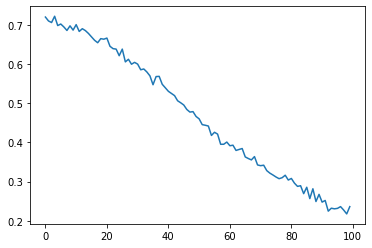

In [48]:
def show_loss(history): 
    plt.plot(history.history['loss'])
    if (history.history['val_loss']):
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_loss(history)

KeyError: 'val_accuracy'

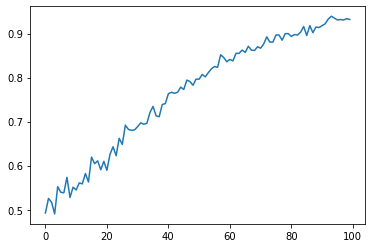

In [49]:
def show_accuracy(history):
    plt.plot(history.history['accuracy'])
    if (history.history['val_accuracy']):
        plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_accuracy(history)

In [52]:


model_loaded = load_model(filepath = filepath_encoder)
model_loaded = model

to_int = np.vectorize(lambda x: int(round(x)))

In [55]:
posX_, posY_ = get_gen(positiveX, positiveY, shuffle=True, batch_size=2000)[0]
negX_, negY_ = get_gen(negativeX, negativeY, shuffle=True, batch_size=2000)[0]

print(positiveX.shape)
print(negativeX.shape)


(484, 13)
(6561, 13)


In [59]:
pos_final = to_int(model_loaded.predict(posX_))
neg_final = to_int(model_loaded.predict(negX_))


model_loaded.evaluate(posX_, posY_)
model_loaded.evaluate(negX_, negY_)

63/63 [==============================] - 8s 126ms/step - loss: 0.9940 - accuracy: 0.6725


[0.994008481502533, 0.6725000143051147]

In [61]:
def check(list):
    pos_count = 0
    neg_count = 0
    for x in list:
        if (x == 1):
            pos_count += 1
        else:
            neg_count += 1
    print("Pos: {} Neg {}".format(pos_count, neg_count))

In [62]:
print("Pos")
check(pos_final)
print("Neg")
check(neg_final)


Pos
Pos: 1851 Neg 149
Neg
Pos: 655 Neg 1345


In [ ]:
model_loaded.predict(posX_)[:10]

In [ ]:
model_loaded.predict(negX_)[:10]

In [ ]:
model_loaded.evaluate(positiveX, positiveY)[1]

In [ ]:
t1 = [0]
t2 = [1]
tf.concat([t1, t2], 0)
